In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

import scanpy as sc

# this script
import scvelo as scv

import sys
sys.path.append('/home/ngr4/project/scnd/scripts/')
import data as scnddata
import bbknn
import phate

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1#0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

# Load data

## Embeddings

Want joint embeddings between CTRL and MUT samples. To that end, may need to jointly load what is there and then use these embeddings (at least see how this looks)

In [3]:
adata = scnddata.load_human(merge=True)

Loading looms...
  for 14 @/home/ngr4/project/scnd/data/human/14/possorted_genome_bam_MAAX6.loom
  for 15162 @/home/ngr4/project/scnd/data/human/15162/possorted_genome_bam_8K1RK.loom
  for 409 @/home/ngr4/project/scnd/data/human/409/possorted_genome_bam_LH1US.loom
  for 1-Jan @/home/ngr4/project/scnd/data/human/1-Jan/possorted_genome_bam_KUW9N.loom
  for 1516 @/home/ngr4/project/scnd/data/human/1516/possorted_genome_bam_WT9NI.loom
  for 2-Jan @/home/ngr4/project/scnd/data/human/2-Jan/possorted_genome_bam_WQPNW.loom
  for 3-Jan @/home/ngr4/project/scnd/data/human/3-Jan/possorted_genome_bam_YJN9W.loom
  for 4092 @/home/ngr4/project/scnd/data/human/4092/possorted_genome_bam_H9UDI.loom


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


looms loaded into sc.AnnData in 0.6-min


In [15]:
# oligodendrocytes only
ol = adata[((adata.obs['ctype']=='Oligodendrocyte progenitor cells') | (adata.obs['ctype']=='Oligodendrocytes')), :]
ol = scnddata.phate_from_adataknn(ol, recalculate=True, umap=True)

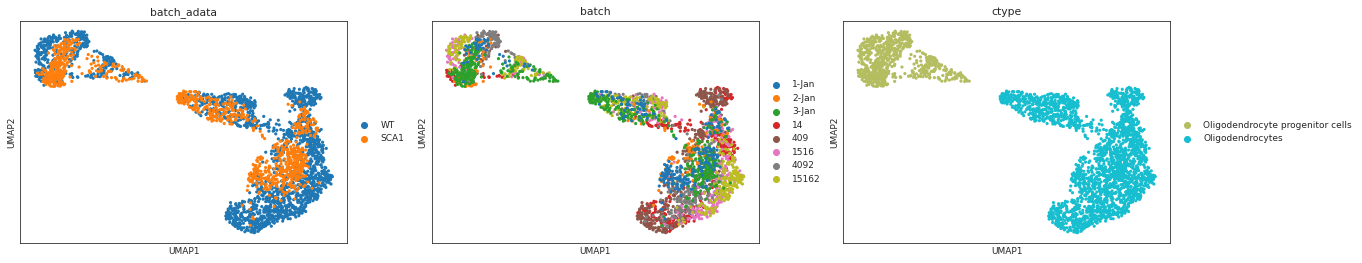

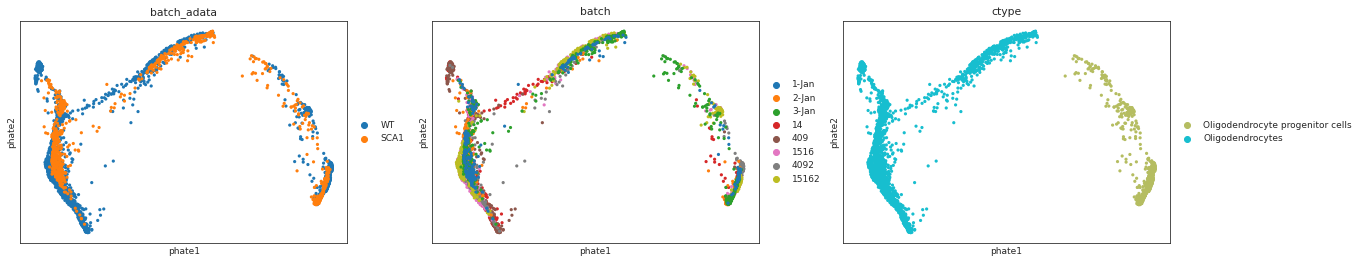

In [18]:
sc.pl.umap(ol, color=['batch_adata', 'batch', 'ctype'])
sc.external.pl.phate(ol, color=['batch_adata', 'batch', 'ctype'])

In [28]:
df

,fpath,fname
0,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,1-Jan_HNT
1,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,14_HNT
2,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,1516_HNT
3,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,2-Jan_HNT
4,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,3-Jan_HNT
...,...,...
60,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,72921_MNT
61,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,72922_MNT
62,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,72931_MNT
63,/ycga-gpfs/sequencers/pacbio/gw92/10x/data_sen...,72932_MNT


In [30]:
out_file = '/home/ngr4/project/scnd/data/processed/leon_tejwani_data_on_ruddle.csv'
df = pd.DataFrame()
with open('/home/ngr4/scratch60/llt_sequencing.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        fpath, fname = os.path.split(line.strip())
        fname, _ = fname.split('_cellranger')
        df = df.append(pd.DataFrame({'fpath':fpath,
                                     'fname':fname}, index=[0]), 
                       ignore_index=True)
df.to_csv(out_file)

# RNA Velocity

## WT 

In [4]:
wt = scnddata.load_human(sca1=None)

In [ ]:
# subset 
wt = wt[((wt.obs['ctype']=='Oligodendrocyte progenitor cells') | (wt.obs['ctype']=='Oligodendrocytes')), :]

In [11]:
# recompute embeddings
wt = scnddata.phate_from_adataknn(wt, recalculate=True)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1942 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 2.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.07 seconds.
Calculated PHATE in 7.64 seconds.


### scvelo

subset just to a particular cell type, as was previously done, though, could learn dynamics on full set O/N

In [12]:
scv.pp.moments(wt, n_pcs=30, n_neighbors=30)
bbknn.bbknn(wt)
scv.pp.neighbors
scv.tl.recover_dynamics(wt)
scv.tl.velocity(wt, mode='stochastic')
scv.tl.velocity_graph(wt)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/20 cores)


  0%|          | 0/2616 [00:00<?, ?gene/s]

    finished (0:08:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


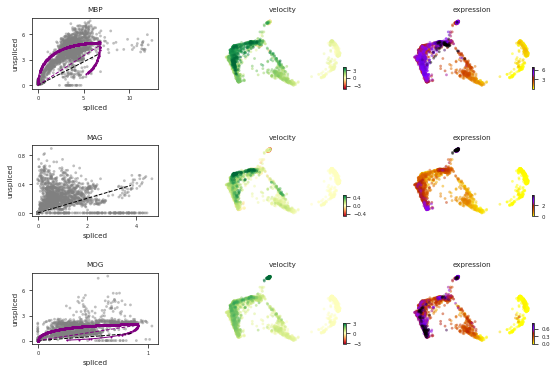

In [13]:
# scv.tl.rank_velocity_genes(wt, match_with='ctype')
scv.pl.velocity(wt, var_names=['MBP','MAG','MOG'], basis = 'phate')

In [ ]:
mode = 'max'

computing latent time using root cell 55 as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


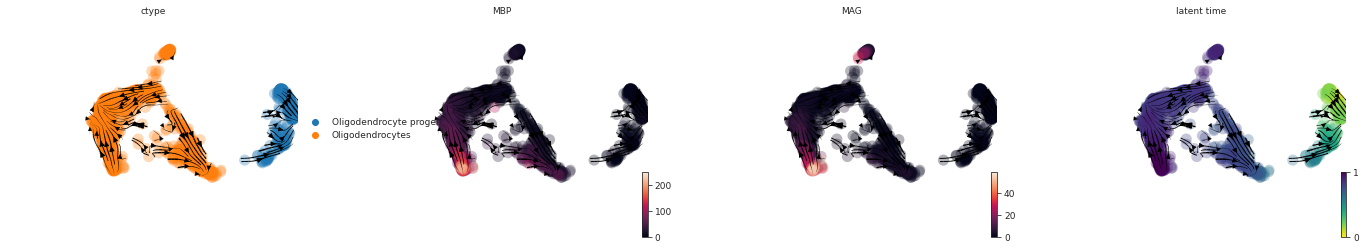

361
computing latent time using root cell 361 as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


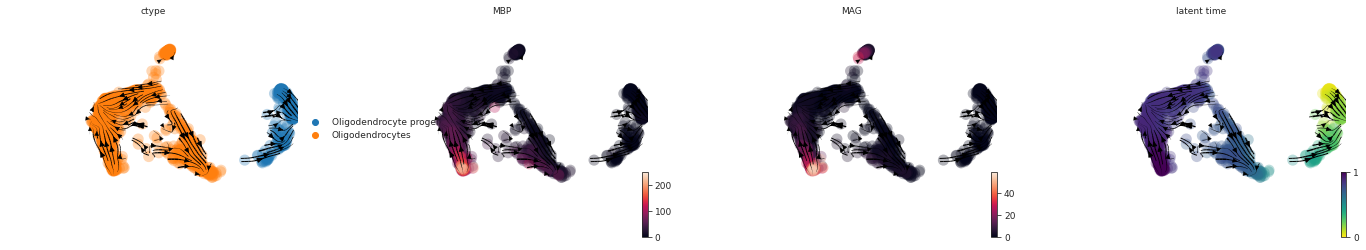

810
computing latent time using root cell 810 as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


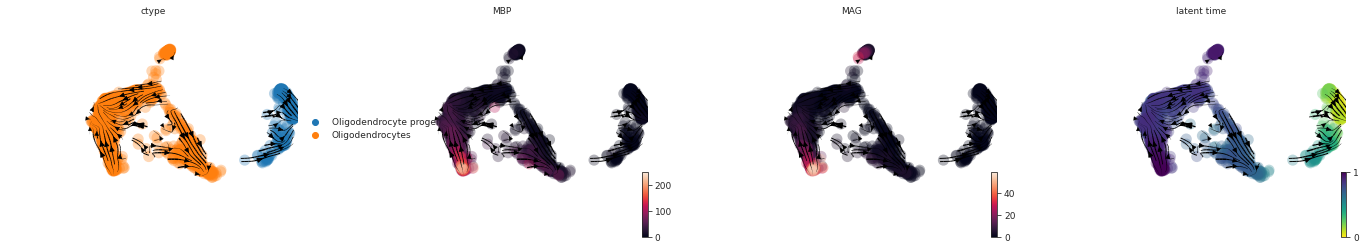

In [22]:
for mode in ['random', 'max', 'max_sum']:
    if mode=='random': 
        idx = np.where(wt.obs['ctype']=='Oligodendrocyte progenitor cells')[0]
        wt.obs['root']=False
        wt.obs['root'][np.random.choice(idx)]=True
        wt.uns['root']=np.where(wt.obs['root'])[0][0]
    elif mode=='max':
        idx = np.where(wt.obs['ctype']=='Oligodendrocyte progenitor cells')[0]
        idx = idx[np.argmax(wt[:,['PDGFRA']].X[idx])]
        wt.obs['root']=False
        wt.obs['root'][idx]=True
        print(np.where(wt.obs['root'])[0][0])
        wt.uns['root']=np.where(wt.obs['root'])[0][0]
    elif mode=='max_sum':
        # with max(sum(PDGFRA, OLIG1, OLIG2 normed expression))
        idx = np.where(wt.obs['ctype']=='Oligodendrocyte progenitor cells')[0]
        idx = idx[np.argmax(wt[:,['PDGFRA','OLIG1','OLIG2']].X.todense()[idx,:].sum(axis=1))]
        wt.obs['root']=False
        wt.obs['root'][idx]=True
        print(np.where(wt.obs['root'])[0][0])
        wt.uns['root']=np.where(wt.obs['root'])[0][0]

    # plot
    scv.tl.recover_latent_time(wt,root_key='root')
    scv.pl.velocity_embedding_stream(wt, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')



## SCA1

In [16]:
sca1 = scnddata.load_human(wt=None)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
# subset 
sca1 = sca1[((sca1.obs['ctype']=='Oligodendrocyte progenitor cells') | (sca1.obs['ctype']=='Oligodendrocytes')), :]

In [18]:
# recompute embeddings
sca1 = scnddata.phate_from_adataknn(sca1, recalculate=True)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1011 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 15
  Calculated optimal t in 0.36 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.10 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.79 seconds.
Calculated PHATE in 1.26 seconds.


### scvelo

subset just to a particular cell type, as was previously done, though, could learn dynamics on full set O/N

In [19]:
scv.pp.moments(sca1, n_pcs=30, n_neighbors=30)
bbknn.bbknn(sca1)
scv.pp.neighbors
scv.tl.recover_dynamics(sca1)
scv.tl.velocity(sca1, mode='stochastic')
scv.tl.velocity_graph(sca1)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/20 cores)


  0%|          | 0/2187 [00:00<?, ?gene/s]

    finished (0:04:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


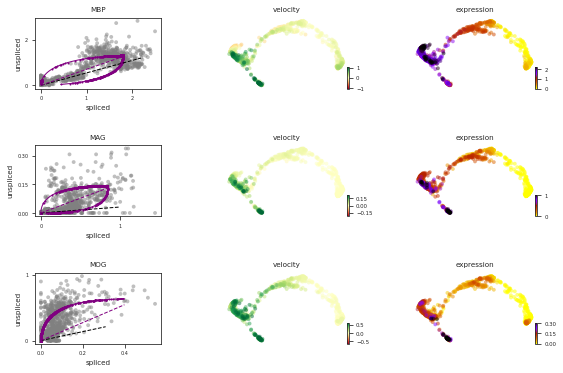

In [20]:
# scv.tl.rank_velocity_genes(sca1, match_with='ctype')
scv.pl.velocity(sca1, var_names=['MBP','MAG','MOG'], basis = 'phate')

In [ ]:
mode = 'max'

computing latent time using root cell 644 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


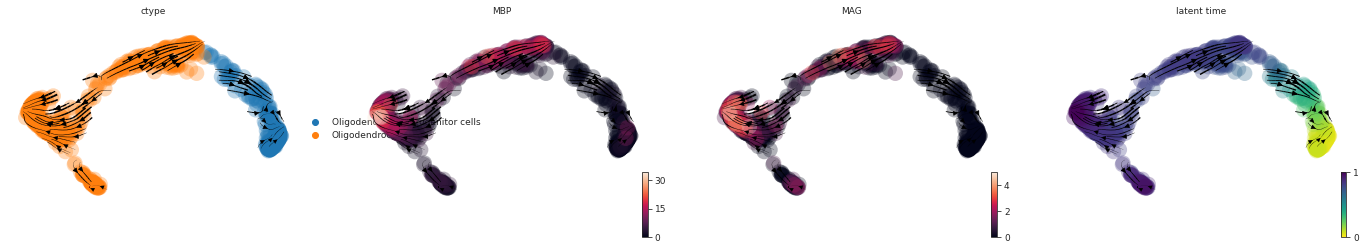

289
computing latent time using root cell 289 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


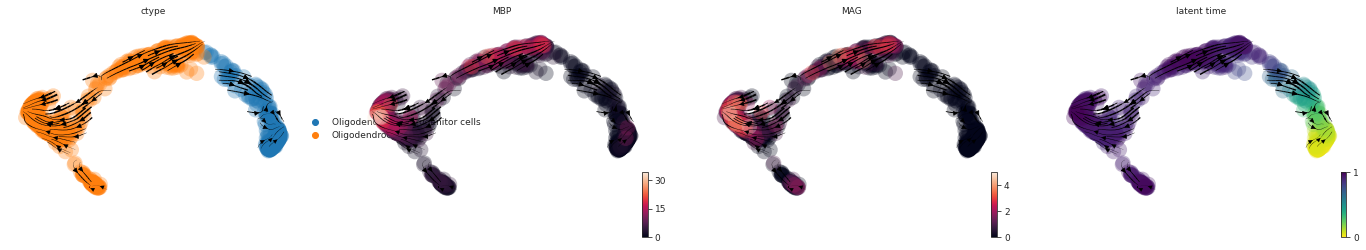

762
computing latent time using root cell 762 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


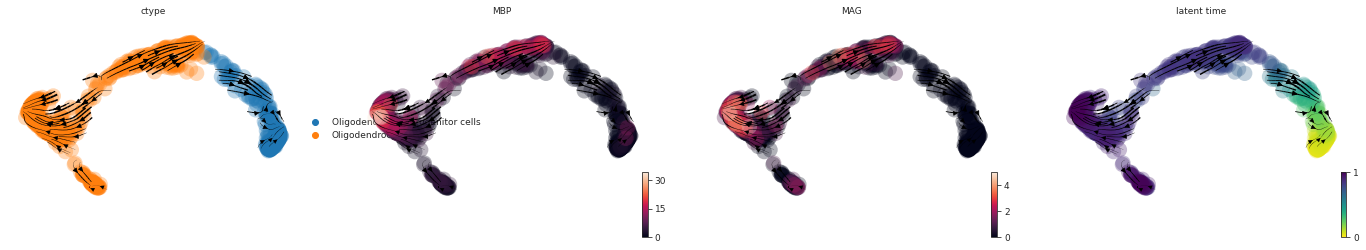

In [23]:
for mode in ['random', 'max', 'max_sum']:
    if mode=='random': 
        idx = np.where(sca1.obs['ctype']=='Oligodendrocyte progenitor cells')[0]
        sca1.obs['root']=False
        sca1.obs['root'][np.random.choice(idx)]=True
        sca1.uns['root']=np.where(sca1.obs['root'])[0][0]
    elif mode=='max':
        idx = np.where(sca1.obs['ctype']=='Oligodendrocyte progenitor cells')[0]
        idx = idx[np.argmax(sca1[:,['PDGFRA']].X[idx])]
        sca1.obs['root']=False
        sca1.obs['root'][idx]=True
        print(np.where(sca1.obs['root'])[0][0])
        sca1.uns['root']=np.where(sca1.obs['root'])[0][0]
    elif mode=='max_sum':
        # with max(sum(PDGFRA, OLIG1, OLIG2 normed expression))
        idx = np.where(sca1.obs['ctype']=='Oligodendrocyte progenitor cells')[0]
        idx = idx[np.argmax(sca1[:,['PDGFRA','OLIG1','OLIG2']].X.todense()[idx,:].sum(axis=1))]
        sca1.obs['root']=False
        sca1.obs['root'][idx]=True
        print(np.where(sca1.obs['root'])[0][0])
        sca1.uns['root']=np.where(sca1.obs['root'])[0][0]

    # plot
    scv.tl.recover_latent_time(sca1,root_key='root')
    scv.pl.velocity_embedding_stream(sca1, basis='phate', color=['ctype','MBP','MAG', 'latent_time'], legend_loc='right_margin')
